In [74]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

Tensorflow V2.11.0
Keras V2.11.0
Python V3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


# Config

In [261]:
N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250


INPUT_SIZE = 64
BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 50
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05


# Load Train Data csv

In [76]:
train = pd.read_csv('/kaggle/input/asl-signs/train.csv')
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 94477


# Add File Path

In [77]:
# Get complete file path to file, add kaggle link to make complete link and column nase is file_path now
def get_complete_path(path):
    return f'/kaggle/input/asl-signs/{path}'
train['file_path'] = train['path'].apply(get_complete_path)

# Ordinally Encode Sign

In [213]:
# Add ordinally Encoded Sign (assign number to each sign name out of the 250 possible signs
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [51]:
display(train.head(10))
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,/kaggle/input/asl-signs/train_landmark_files/2...,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,/kaggle/input/asl-signs/train_landmark_files/2...,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,/kaggle/input/asl-signs/train_landmark_files/1...,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,/kaggle/input/asl-signs/train_landmark_files/2...,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,/kaggle/input/asl-signs/train_landmark_files/6...,164
5,train_landmark_files/26734/1000241583.parquet,26734,1000241583,duck,/kaggle/input/asl-signs/train_landmark_files/2...,67
6,train_landmark_files/26734/1000255522.parquet,26734,1000255522,minemy,/kaggle/input/asl-signs/train_landmark_files/2...,143
7,train_landmark_files/32319/1000278229.parquet,32319,1000278229,lips,/kaggle/input/asl-signs/train_landmark_files/3...,134
8,train_landmark_files/37055/100035691.parquet,37055,100035691,flower,/kaggle/input/asl-signs/train_landmark_files/3...,86
9,train_landmark_files/29302/100039661.parquet,29302,100039661,time,/kaggle/input/asl-signs/train_landmark_files/2...,220


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   path            94477 non-null  object  
 1   participant_id  94477 non-null  int64   
 2   sequence_id     94477 non-null  int64   
 3   sign            94477 non-null  category
 4   file_path       94477 non-null  object  
 5   sign_ord        94477 non-null  int16   
dtypes: category(1), int16(1), int64(2), object(2)
memory usage: 3.3+ MB


None

# Landmark Indices

In [83]:
# The different type of hand movements are left hand, right hand, pose, and lips int the database. 
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468

# Constants defining landmark indices based on a library like MediaPipe
LIPS_IDXS0 = np.array([
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
])
LEFT_HAND_IDXS0 = np.arange(468, 489)
RIGHT_HAND_IDXS0 = np.arange(522, 543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

# Concatenate indices for the dominant hands
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0))
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size

# Processed data indices using np.isin for optimized searching and mapping
def get_processed_indices(dominant_indices, specific_indices):
    return np.flatnonzero(np.isin(dominant_indices, specific_indices))

# Calculate processed indices
LIPS_IDXS = get_processed_indices(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)
LEFT_HAND_IDXS = get_processed_indices(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)
RIGHT_HAND_IDXS = get_processed_indices(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)
HAND_IDXS = get_processed_indices(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)
POSE_IDXS = get_processed_indices(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)

LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

# Process Data Tensorflow

In [80]:
#defined by the google Competition 
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path, columns=['x', 'y', 'z']):
    try:
        data = pd.read_parquet(pq_path, columns=columns)
        n_frames = data.shape[0] // ROWS_PER_FRAME
        if data.shape[0] % ROWS_PER_FRAME != 0:
            raise ValueError("Total number of rows is not a multiple of ROWS_PER_FRAME.")
        reshaped_data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(columns))
        return reshaped_data.astype(np.float32)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [89]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
            # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
            [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
            # Y coordinates stay intact
            [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
            # Z coordinates stay intact
            [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0)],dtype=tf.float32 )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

In [86]:
def get_data(file_path):
    data = preprocess_layer(load_relevant_data_subset(file_path))
    return data

# Create Dataset

In [87]:
def preprocess_data():
    # Initialize data structures
    X = np.zeros((N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS), dtype=np.float32)
    y = np.zeros(N_SAMPLES, dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full((N_SAMPLES, INPUT_SIZE), -1, dtype=np.float32)

    # Process each sample
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Processing {row_idx}/{N_SAMPLES} samples')

        data, non_empty_frame_idxs = get_data(file_path)
        if np.isnan(data).any():
            raise ValueError(f'NaN values found at index {row_idx}')

        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs

    # Save arrays to files
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)

    return X, y, NON_EMPTY_FRAME_IDXS

def split_data(X, y, groups):
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=42)
    train_idxs, val_idxs = next(splitter.split(X, y, groups=groups))
    return train_idxs, val_idxs

def save_split_data(X, y, NON_EMPTY_FRAME_IDXS, train_idxs, val_idxs):
    np.save('X_train.npy', X[train_idxs])
    np.save('y_train.npy', y[train_idxs])
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS[train_idxs])
    np.save('X_val.npy', X[val_idxs])
    np.save('y_val.npy', y[val_idxs])
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS[val_idxs])


In [90]:
# Preprocess All Data From Scratch
X, y, NON_EMPTY_FRAME_IDXS = preprocess_data()
train_idxs, val_idxs = split_data(X, y, train['participant_id'].values)
save_split_data(X, y, NON_EMPTY_FRAME_IDXS, train_idxs, val_idxs)
ROOT_DIR = '.'
    

# Load Train
X_train = np.load(f'{ROOT_DIR}/X_train.npy')
y_train = np.load(f'{ROOT_DIR}/y_train.npy')
NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
# Load Val
X_val = np.load(f'{ROOT_DIR}/X_val.npy')
y_val = np.load(f'{ROOT_DIR}/y_val.npy')
NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
# Define validation Data
validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)




  0%|          | 0/94477 [00:00<?, ?it/s]

Processing 0/94477 samples
Processing 5000/94477 samples
Processing 10000/94477 samples
Processing 15000/94477 samples
Processing 20000/94477 samples
Processing 25000/94477 samples
Processing 30000/94477 samples
Processing 35000/94477 samples
Processing 40000/94477 samples
Processing 45000/94477 samples
Processing 50000/94477 samples
Processing 55000/94477 samples
Processing 60000/94477 samples
Processing 65000/94477 samples
Processing 70000/94477 samples
Processing 75000/94477 samples
Processing 80000/94477 samples
Processing 85000/94477 samples
Processing 90000/94477 samples


NameError: name 'print_shape_dtype' is not defined

In [91]:
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

# NaN Values X_train: 0


# Feature Statistics - Lips, Hands, and Pose

In [115]:
def get_mean_std(X_train, indices, feature_name):
    n_dims = N_DIMS
    # Initialize the mean and std arrays
    MEAN_X = np.zeros([indices.size], dtype=np.float32)
    MEAN_Y = np.zeros([indices.size], dtype=np.float32)
    STD_X = np.zeros([indices.size], dtype=np.float32)
    STD_Y = np.zeros([indices.size], dtype=np.float32)
    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,indices], [2,3,0,1]).reshape([indices.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                MEAN_X[col] = v.mean()
                STD_X[col] = v.std()
            if dim == 1: # Y
                MEAN_Y[col] = v.mean()
                STD_Y[col] = v.std()
    MEAN = np.array([MEAN_X, MEAN_Y]).T
    STD = np.array([STD_X, STD_Y]).T
    
    return MEAN, STD

LIPS_MEAN, LIPS_STD = get_mean_std(X_train, LIPS_IDXS, 'Lips ')
LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_mean_std(X_train, LEFT_HAND_IDXS, 'Left Hand')
POSE_MEAN, POSE_STD = get_mean_std(X_train, POSE_IDXS, 'Pose')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [128]:
print(LIPS_STD.shape)
print(LEFT_HANDS_MEAN.shape)
print(POSE_MEAN.shape)

(40, 2)
(21, 2)
(5, 2)


# Model Config

In [119]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6
# Dense layer units for landmarksK
LANDMARK_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer settings 
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)

# Activations
GELU = tf.keras.activations.gelu


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [194]:
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [174]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks, num_heads=8, d_model=UNITS, mlp_ratio=MLP_RATIO):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
        
        # Initialize lists to hold the layers within each transformer block
        self.mhas = [MultiHeadAttention(d_model, num_heads) for _ in range(num_blocks)]
        self.feed_forwards = [tf.keras.Sequential([
            tf.keras.layers.Dense(d_model * mlp_ratio, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
            tf.keras.layers.Dense(d_model, kernel_initializer=INIT_HE_UNIFORM),
        ]) for _ in range(num_blocks)]
        
        # Layer normalization layer
        self.ln1 = [tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS) for _ in range(num_blocks)]
        self.ln2 = [tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS) for _ in range(num_blocks)]

    def call(self, x, attention_mask=None):
        # Process input through each block
        for i in range(self.num_blocks):
            attn_output = self.mhas[i](self.ln1[i](x), attention_mask)
            x = x + attn_output  # Apply residual connection
            x = x + self.feed_forwards[i](self.ln2[i](x))  # Apply second residual connection after MLP
        
        return x

# Landmark Embedding

In [175]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmarks in the frame, initialized with zeros
        self.empty_embedding = tf.zeros((1, 1, self.units))  # Using a constant zero tensor
        
        # Dense layers for embedding
        self.dense1 = tf.keras.layers.Dense(
            self.units, 
            use_bias=False, 
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            activation=tf.keras.activations.gelu,
            name=f'{self.name}_dense_1'
        )
        self.dense2 = tf.keras.layers.Dense(
            self.units, 
            use_bias=False, 
            kernel_initializer=tf.keras.initializers.HeUniform(),
            name=f'{self.name}_dense_2'
        )

    def call(self, x):
        # Compute a mask where landmarks are missing (all features are zero)
        mask = tf.reduce_all(tf.equal(x, 0), axis=2, keepdims=True)
        
        # Apply the first dense layer and activation
        x = self.dense1(x)
        # Apply the second dense layer
        x = self.dense2(x)
        
        # Use broadcasting to fill missing landmarks with the zero embedding
        return tf.where(mask, self.empty_embedding, x)

# Embedding

In [176]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()

    def get_diffs(self, l):
        # Efficient computation of pairwise differences using broadcasting
        diffs = l[:, :, tf.newaxis, :] - l[:, tf.newaxis, :, :]
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, l.shape[2] * l.shape[2]])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE + 1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layers for Landmarks
        self.lips_embedding = LandmarkEmbedding(LANDMARK_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(LANDMARK_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(LANDMARK_UNITS, 'pose')
        # Learnable weights for landmarks
        self.landmark_weights = self.add_weight(name='landmark_weights', shape=[3], initializer=tf.keras.initializers.Zeros(), trainable=True)
        # Fully Connected Layers for combined embeddings
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, activation=GELU, use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Dense(UNITS, use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')

    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Embeddings for each landmark
        lips_embedding = self.lips_embedding(lips0)
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        pose_embedding = self.pose_embedding(pose0)

        # Weighted mean of embeddings using softmax-normalized weights
        weights = tf.nn.softmax(self.landmark_weights)[tf.newaxis, tf.newaxis, tf.newaxis, :]
        embeddings = tf.stack([lips_embedding, left_hand_embedding, pose_embedding], axis=-1)
        x = tf.reduce_sum(weights * embeddings, axis=-1)

        # Fully Connected Layers
        x = self.fc(x)

        # Add Positional Embedding
        positional_indices = tf.clip_by_value(
            tf.math.divide_no_nan(non_empty_frame_idxs, tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True)) * INPUT_SIZE,
            0,
            INPUT_SIZE
        )
        positional_indices = tf.cast(positional_indices, tf.int32)
        x += self.positional_embedding(positional_indices)

        return x



# Augmentation

In [177]:
# Not used, adds random X/y translation to input on samples level
import tensorflow as tf

class Augmentation(tf.keras.layers.Layer):
    def __init__(self, noise_std):
        super(Augmentation, self).__init__()
        self.noise_std = noise_std
    
    def add_noise(self, t):
        # Generate random noise only once and expand its dimensions to match t
        B = tf.shape(t)[0]
        random_noise = tf.random.normal([B, 1, 1, tf.shape(t)[-1]], stddev=self.noise_std)
        # Only add noise where t is not zero
        return tf.where(t == 0.0, 0.0, t + random_noise)
    
    def call(self, lips0, left_hand0, pose0, training=False):
        if training:
            # Apply noise augmentation to each set of features if training is True
            lips0 = self.add_noise(lips0)
            left_hand0 = self.add_noise(left_hand0)
            pose0 = self.add_noise(pose0)
        
        return lips0, left_hand0, pose0


# Sparse Categorical Crossentropy With Label Smoothing

In [178]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

# Model

In [195]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input(shape=(INPUT_SIZE, N_COLS, N_DIMS), dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input(shape=(INPUT_SIZE,), dtype=tf.float32, name='non_empty_frame_idxs')
    
    # Padding Mask
    mask0 = tf.cast(non_empty_frame_idxs != -1, tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    
    # Random Frame Masking
    mask = tf.cast(tf.random.uniform(tf.shape(mask0)) > 0.25, tf.float32) * mask0
    
    # Ensure there is at least one frame per sample not masked
    mask = tf.where(tf.reduce_sum(mask, axis=1, keepdims=True) == 0, mask0, mask)
    
    # Normalize features and apply masks
    def normalize_and_mask(x, start, num_features, mean, std):
        feature_slice = tf.slice(x, [0, 0, start, 0], [-1, INPUT_SIZE, num_features, 2])
        normalized_features = tf.where(feature_slice == 0.0, 0.0, (feature_slice - mean) / std)
        return tf.reshape(normalized_features, [-1, INPUT_SIZE, num_features * 2])
    
    # Apply normalization and masking
    lips = normalize_and_mask(frames, LIPS_START, 40, LIPS_MEAN, LIPS_STD)
    left_hand = normalize_and_mask(frames, 40, 21, LEFT_HANDS_MEAN, LEFT_HANDS_STD)
    pose = normalize_and_mask(frames, 61, 5, POSE_MEAN, POSE_STD)
    
    # Embedding and Transformer
    embedding_layer = Embedding()
    transformer_layer = Transformer(NUM_BLOCKS)
    x = embedding_layer(lips, left_hand, pose, non_empty_frame_idxs)
    x = transformer_layer(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * tf.expand_dims(mask[:, :, 0], -1), axis=1) / tf.reduce_sum(mask, axis=1)
    
    # Classifier
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    # Model setup
    model = tf.keras.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    model.compile(
        loss=scce_with_ls,
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc')
        ]
    )
    
    return model


In [196]:
tf.keras.backend.clear_session()
model = get_model()

In [167]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

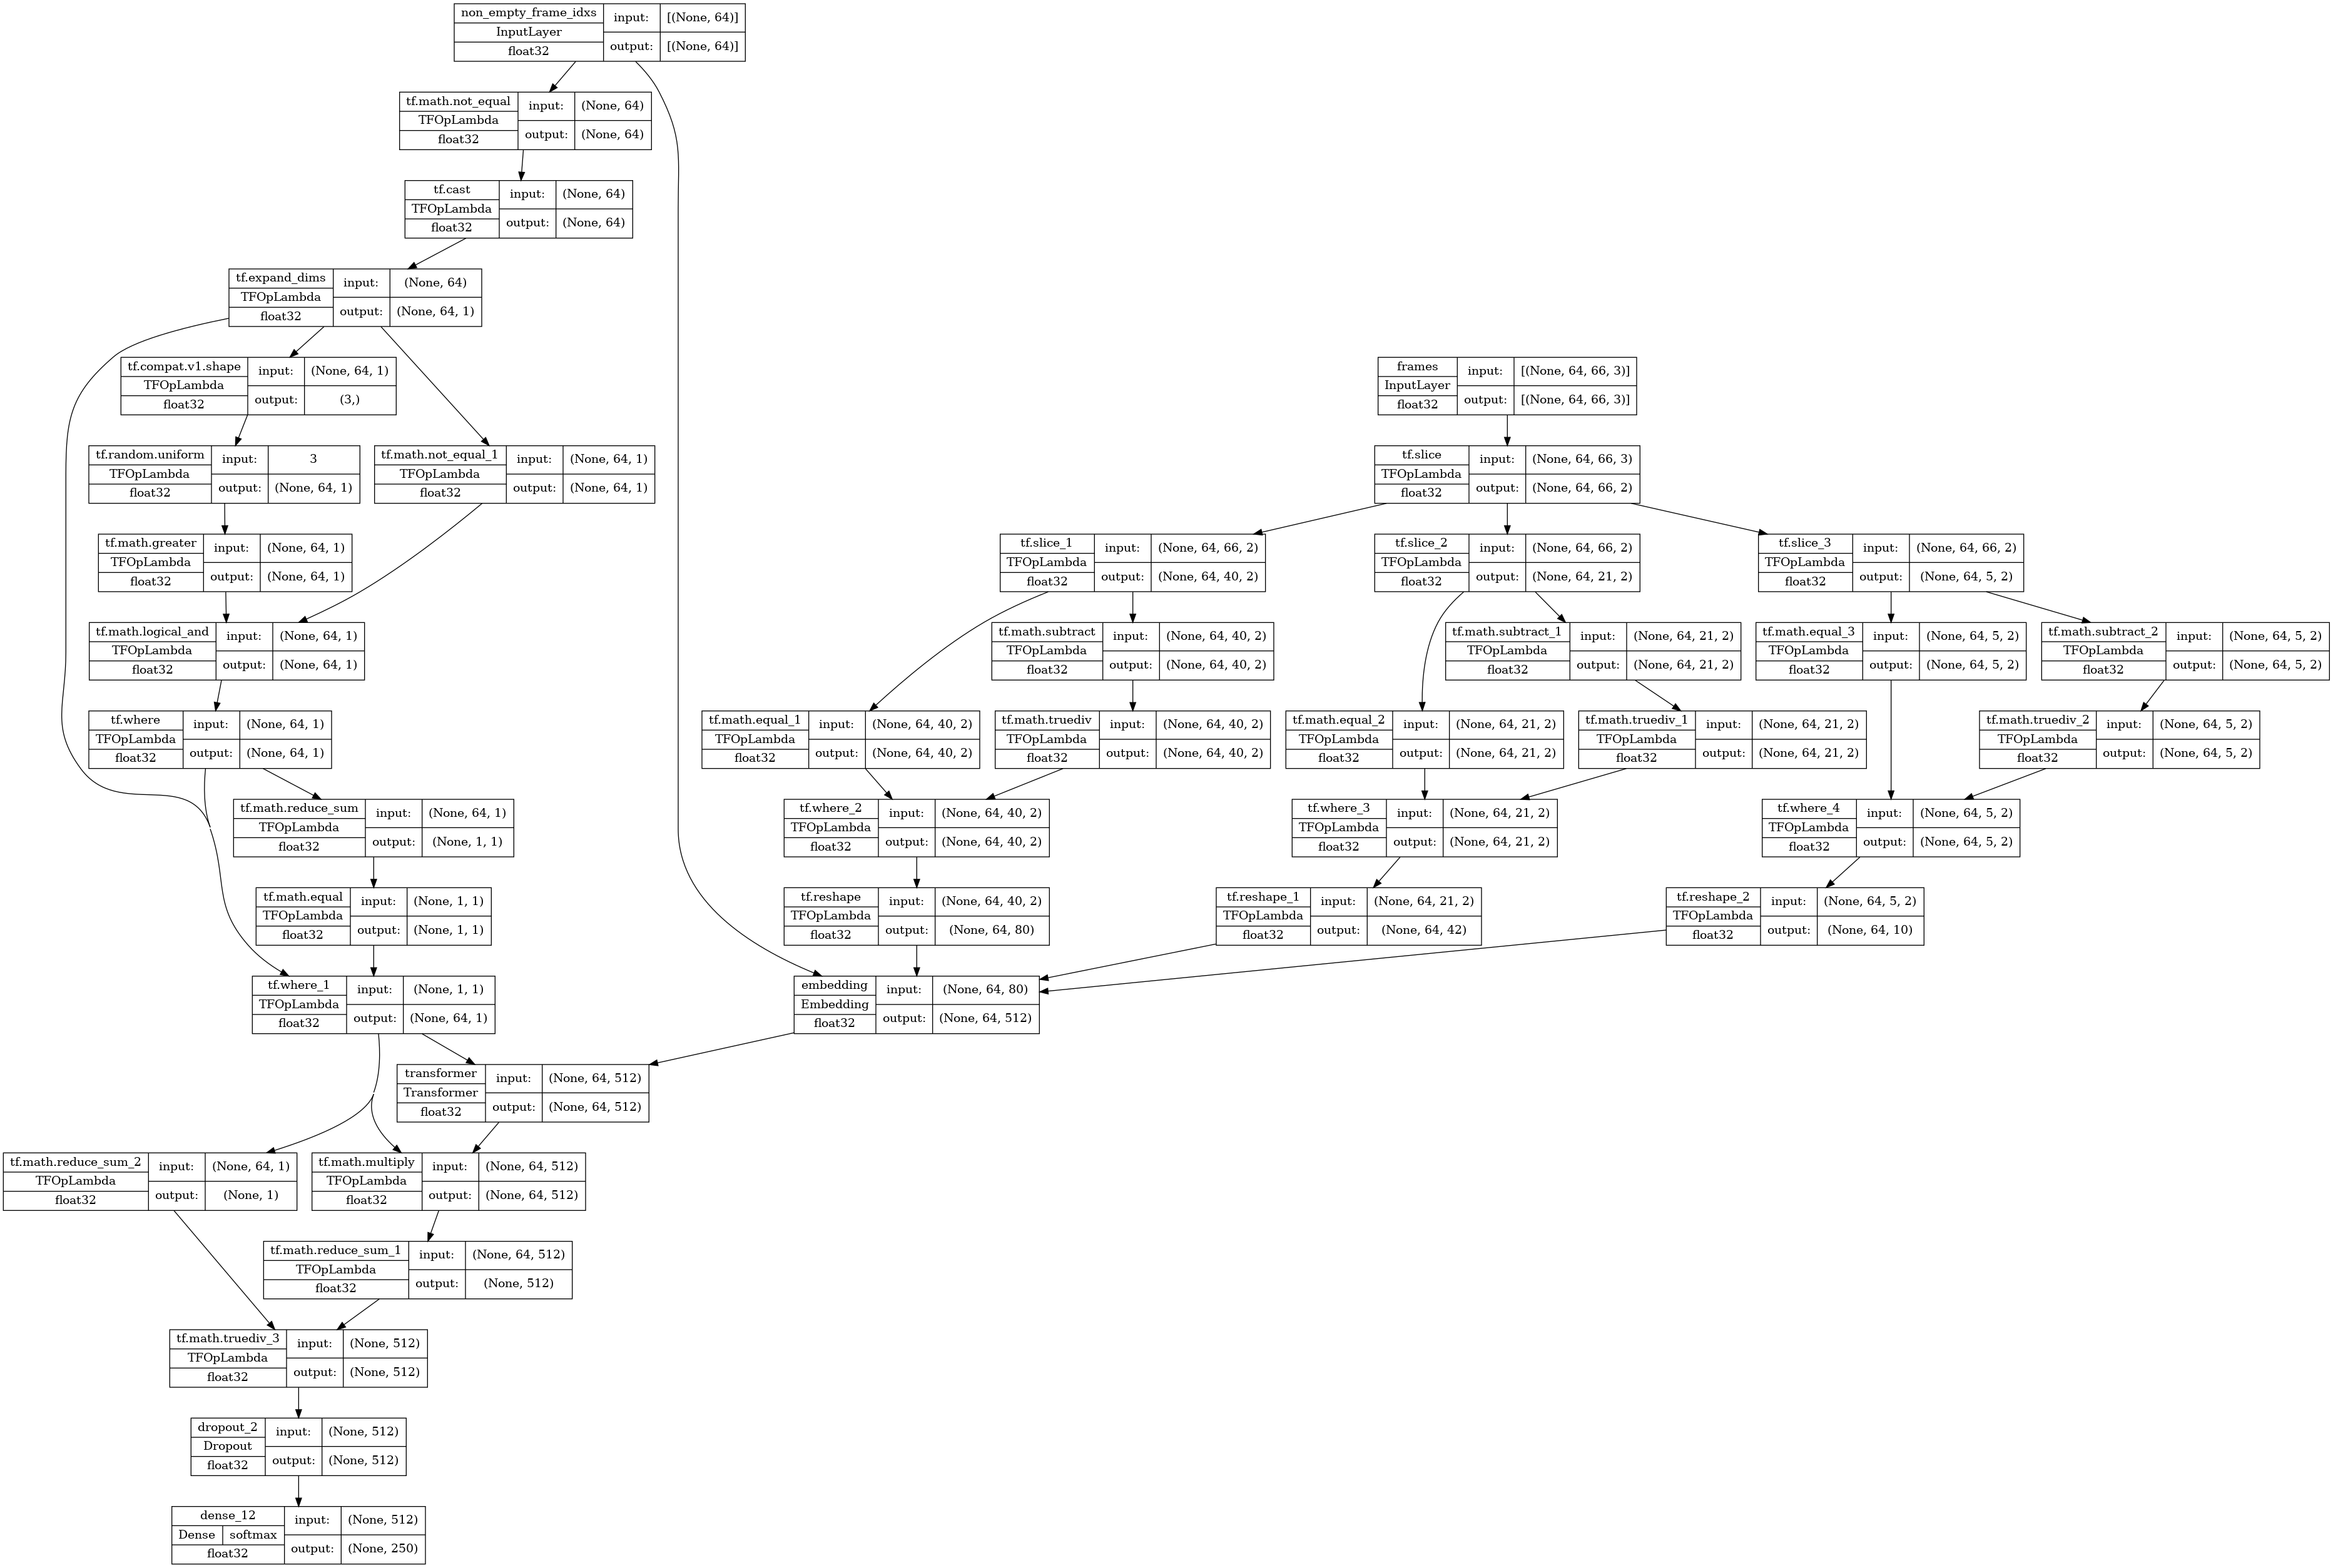

In [137]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# Learning Rate Scheduler

In [242]:
def learning_rate(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    current_step = tf.cast(current_step, tf.float32)
    num_warmup_steps = tf.cast(num_warmup_steps, tf.float32)
    num_training_steps = tf.cast(num_training_steps, tf.float32)
    
    # Compute warmup learning rate using exponential increase
    warmup_lr = lr_max * tf.pow(0.10, (num_warmup_steps - current_step))

    # After warmup, apply cosine decay to the learning rate
    progress = (current_step - num_warmup_steps) / tf.maximum(1.0, num_training_steps - num_warmup_steps)
    cosine_decay = 0.5 * (1.0 + tf.cos(tf.constant(math.pi) * num_cycles * 2.0 * progress))
    decayed_lr = lr_max * cosine_decay

    # Use a condition to switch between warmup and decay phase
    learning_rate = tf.where(current_step < num_warmup_steps, warmup_lr, decayed_lr)

    return learning_rate

In [243]:
# Learning rate for encoder
LR_SCHEDULE = [learning_rate(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step])

# Weight Decay Callback

In [244]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        super(WeightDecayCallback, self).__init__()
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        # Get the current learning rate from the optimizer
        current_lr = self.model.optimizer.learning_rate
        
        # If the learning rate is a callable (dynamic), compute its current value
        if callable(current_lr):
            current_lr = current_lr(self.model.optimizer.iterations)
        
        # Update weight decay in the optimizer
        self.model.optimizer.weight_decay = current_lr * self.wd_ratio
        
        print(f'learning rate: {current_lr.numpy():.2e}, weight decay: {self.model.optimizer.weight_decay.numpy():.2e}')


# Train

In [245]:
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Precompute the indices for each class only once to avoid repetitive computation
    CLASS2IDXS = {i: np.flatnonzero(y == i) for i in range(NUM_CLASSES)}

    # Initialize arrays to store batch data
    X_batch = np.zeros([NUM_CLASSES * n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.repeat(np.arange(NUM_CLASSES), n)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES * n, INPUT_SIZE], dtype=np.float32)
    
    while True:
        # Randomly select indices for each class to create a balanced batch
        for i, idxs in CLASS2IDXS.items():
            selected_idxs = np.random.choice(idxs, n, replace=len(idxs) < n)
            batch_start = i * n
            batch_end = batch_start + n
            X_batch[batch_start:batch_end] = X[selected_idxs]
            non_empty_frame_idxs_batch[batch_start:batch_end] = NON_EMPTY_FRAME_IDXS[selected_idxs]

        yield {'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch}, y_batch


In [260]:
tf.keras.backend.clear_session

# Actual Training
history = model.fit(
        x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
        steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
        epochs=N_EPOCHS,
        # Only used for validation data since training data is a generator
        batch_size=BATCH_SIZE,
        validation_data=validation_data,
        callbacks=[
            lr_callback,
            WeightDecayCallback(),
        ]
    )

learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/2
80/80 [==============================] - 51s 637ms/step - loss: 2.3076 - acc: 0.9275 - top_5_acc: 0.9906 - top_10_acc: 0.9956 - val_loss: 3.0501 - val_acc: 0.6630 - val_top_5_acc: 0.8744 - val_top_10_acc: 0.9128 - lr: 0.0010
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 2/2
80/80 [==============================] - 51s 637ms/step - loss: 2.4011 - acc: 0.9028 - top_5_acc: 0.9848 - top_10_acc: 0.9925 - val_loss: 2.9880 - val_acc: 0.6835 - val_top_5_acc: 0.8793 - val_top_10_acc: 0.9188 - lr: 9.9975e-04


In [225]:
# Save Model Weights
model.save_weights('model.h5')

In [226]:
y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

446/446 - 6s - 6s/epoch - 14ms/step


# Classification Report

In [249]:
classification_report = sklearn.metrics.classification_report(y_val,
                                                              y_val_pred,
                                                              target_names=labels,
                                                              output_dict=True)
print_classification_report()

{'TV': {'precision': 0.7910447761194029,
  'recall': 0.8833333333333333,
  'f1-score': 0.8346456692913385,
  'support': 60},
 'after': {'precision': 0.46153846153846156,
  'recall': 0.2033898305084746,
  'f1-score': 0.28235294117647064,
  'support': 59},
 'airplane': {'precision': 1.0,
  'recall': 0.9473684210526315,
  'f1-score': 0.972972972972973,
  'support': 57},
 'all': {'precision': 0.7272727272727273,
  'recall': 0.6779661016949152,
  'f1-score': 0.7017543859649122,
  'support': 59},
 'alligator': {'precision': 0.6666666666666666,
  'recall': 0.6557377049180327,
  'f1-score': 0.6611570247933883,
  'support': 61},
 'animal': {'precision': 0.49333333333333335,
  'recall': 0.7708333333333334,
  'f1-score': 0.6016260162601627,
  'support': 48},
 'another': {'precision': 0.8260869565217391,
  'recall': 0.7450980392156863,
  'f1-score': 0.7835051546391751,
  'support': 51},
 'any': {'precision': 0.6216216216216216,
  'recall': 0.7931034482758621,
  'f1-score': 0.696969696969697,
  'su

{'TV': {'precision': 0.7910447761194029,
  'recall': 0.8833333333333333,
  'f1-score': 0.8346456692913385,
  'support': 60},
 'after': {'precision': 0.46153846153846156,
  'recall': 0.2033898305084746,
  'f1-score': 0.28235294117647064,
  'support': 59},
 'airplane': {'precision': 1.0,
  'recall': 0.9473684210526315,
  'f1-score': 0.972972972972973,
  'support': 57},
 'all': {'precision': 0.7272727272727273,
  'recall': 0.6779661016949152,
  'f1-score': 0.7017543859649122,
  'support': 59},
 'alligator': {'precision': 0.6666666666666666,
  'recall': 0.6557377049180327,
  'f1-score': 0.6611570247933883,
  'support': 61},
 'animal': {'precision': 0.49333333333333335,
  'recall': 0.7708333333333334,
  'f1-score': 0.6016260162601627,
  'support': 48},
 'another': {'precision': 0.8260869565217391,
  'recall': 0.7450980392156863,
  'f1-score': 0.7835051546391751,
  'support': 51},
 'any': {'precision': 0.6216216216216216,
  'recall': 0.7931034482758621,
  'f1-score': 0.696969696969697,
  'su

# Training History

In [252]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(10, 5))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    epochs = np.arange(1, N_EPOCHS + 1)

    # Check if validation data exists
    val_key = f'val_{metric}'
    has_val = val_key in history.history
    
    # Plot training data
    plt.plot(epochs, values, label='Train', marker='o', linestyle='-')
    best_idx = f_best(values)
    plt.scatter(best_idx + 1, values[best_idx], color='red', s=100, label='Best Train')

    # Plot validation data if available
    if has_val:
        val_values = history.history[val_key]
        plt.plot(epochs, val_values, label='Validation', marker='o', linestyle='--')
        val_best_idx = f_best(val_values)
        plt.scatter(val_best_idx + 1, val_values[val_best_idx], color='green', s=100, label='Best Validation')

    # Set plot titles and labels
    plt.title(f'Model {metric.capitalize()} over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    
    # Apply custom settings
    if ylim:
        plt.ylim(ylim)
    if yscale:
        plt.yscale(yscale)
    if yticks:
        plt.yticks(yticks)

    # Improve tick settings
    plt.xticks(epochs, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

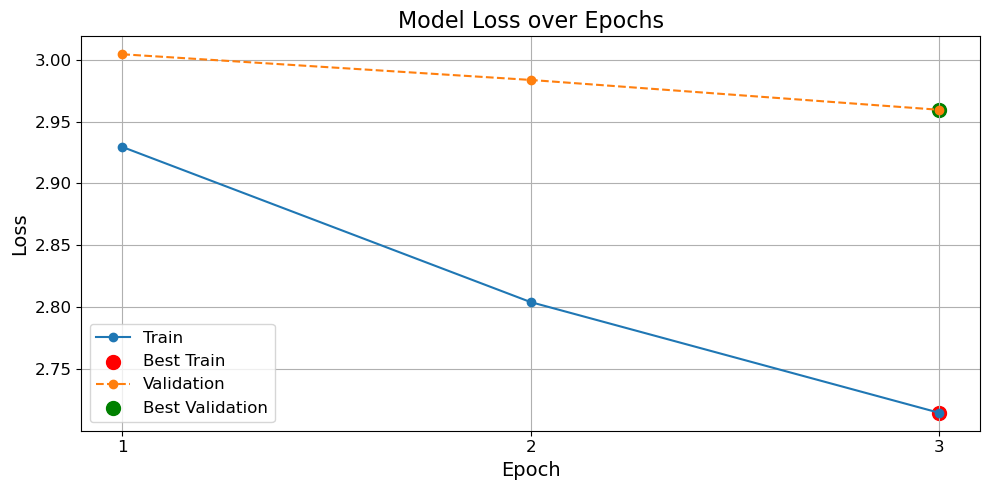

In [253]:
plot_history_metric('loss', f_best=np.argmin)

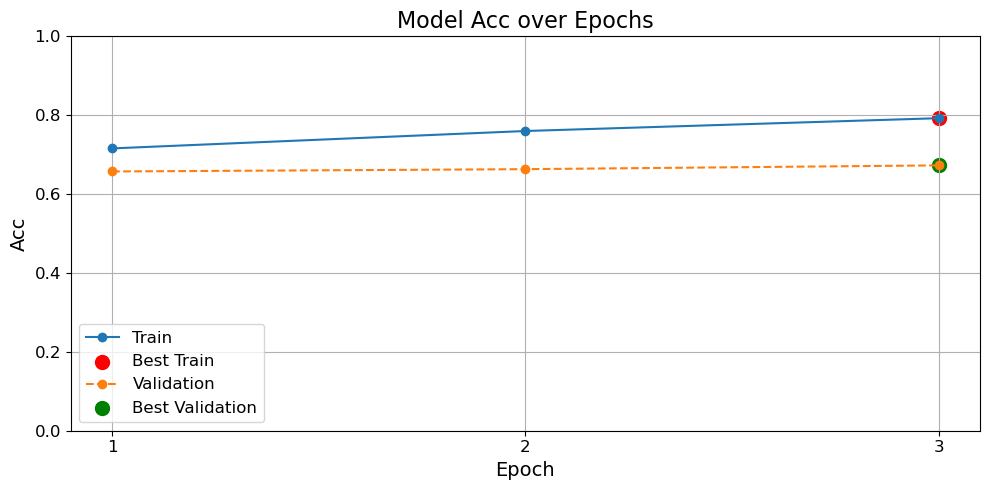

In [256]:
plot_history_metric('acc', ylim=[0,1])

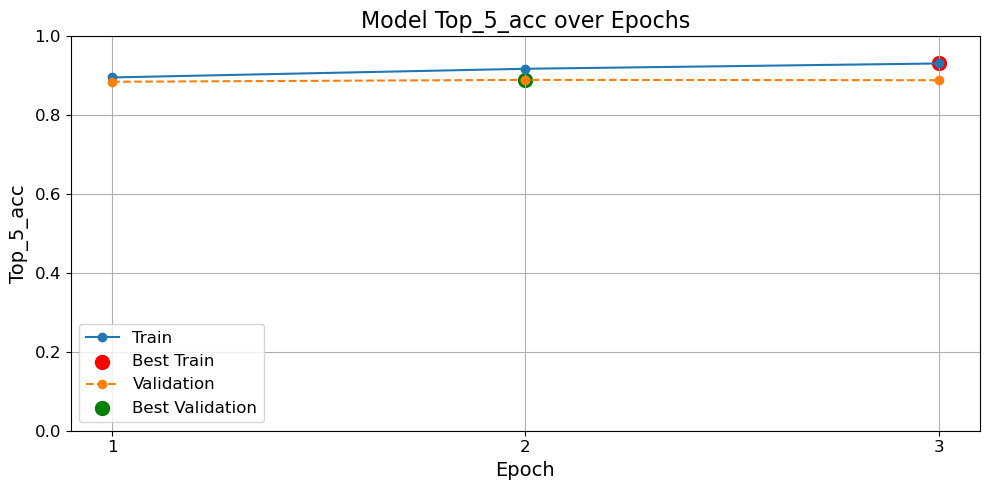

In [258]:
plot_history_metric('top_5_acc', ylim=[0,1])

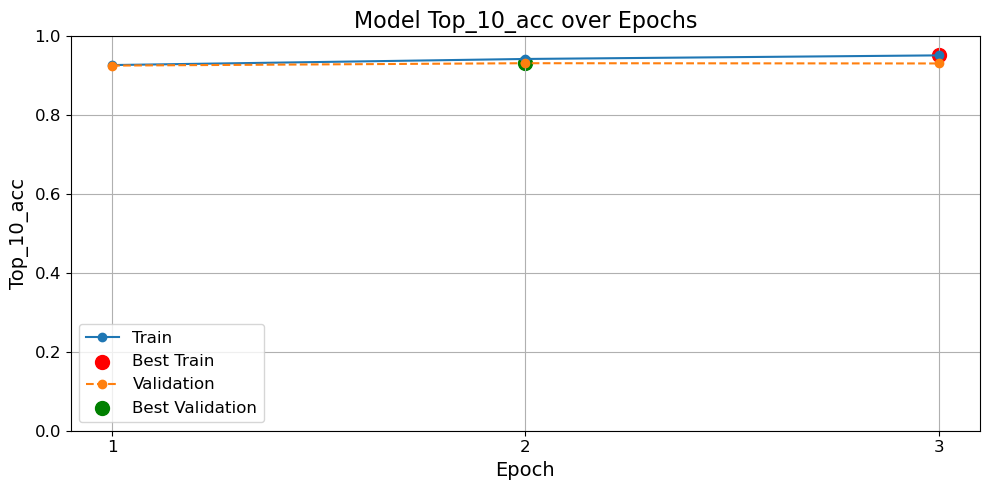

In [259]:
plot_history_metric('top_10_acc', ylim=[0,1])